In [2706]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import re
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import f_regression, mutual_info_regression
from scipy.stats import boxcox

Избавимся от вывода предупреждений

In [2707]:
import warnings
warnings.filterwarnings("ignore")

In [2708]:
df = pd.read_csv('data_for_train.csv')

In [2709]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279792 entries, 0 to 279791
Data columns (total 77 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   city                                 279792 non-null  object 
 1   floor                                103555 non-null  object 
 2   id                                   279792 non-null  object 
 3   lat                                  279792 non-null  float64
 4   lng                                  279792 non-null  float64
 5   osm_amenity_points_in_0.001          279792 non-null  int64  
 6   osm_amenity_points_in_0.005          279792 non-null  int64  
 7   osm_amenity_points_in_0.0075         279792 non-null  int64  
 8   osm_amenity_points_in_0.01           279792 non-null  int64  
 9   osm_building_points_in_0.001         279792 non-null  int64  
 10  osm_building_points_in_0.005         279792 non-null  int64  
 11  osm_building_

In [2710]:
test = pd.read_csv('data_for_test.csv')

In [2711]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974 entries, 0 to 2973
Data columns (total 76 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   city                                 2974 non-null   object 
 1   floor                                1673 non-null   object 
 2   id                                   2974 non-null   object 
 3   osm_amenity_points_in_0.001          2974 non-null   int64  
 4   osm_amenity_points_in_0.005          2974 non-null   int64  
 5   osm_amenity_points_in_0.0075         2974 non-null   int64  
 6   osm_amenity_points_in_0.01           2974 non-null   int64  
 7   osm_building_points_in_0.001         2974 non-null   int64  
 8   osm_building_points_in_0.005         2974 non-null   int64  
 9   osm_building_points_in_0.0075        2974 non-null   int64  
 10  osm_building_points_in_0.01          2974 non-null   int64  
 11  osm_catering_points_in_0.001  

In [2712]:
for col in df.columns:
    if col not in test.columns:
        print(col)

per_square_meter_price


Присвоим обучающей выборке значение признака label = 0 и 1 для тестовой, чтобы потом можно было отличать их

In [2713]:
df.loc[:, 'label'] = 0
test.loc[:, 'label'] = 1
test.loc[:, 'per_square_meter_price'] = np.nan

Сделаем один общий датасет из тестовой и обучающе выборки для работы с ними одновременно

In [2714]:
data = pd.concat([df, test])

In [2715]:
del df
del test

Разделим колонки на те, которые имеют пропуски и на те, которые их не имеют

In [2716]:
cols_with_null = data.isnull().sum()[data.isnull().sum() > 0].index
full_cols = data.isnull().sum()[data.isnull().sum() == 0].index

Создадим функцию по определению выбросов и границ, за которыми они находятся

In [2717]:
def detect_outlires(col, whis=1.5):
    print(col.name)
    quan_25 = np.quantile(col, 0.25)
    quan_75 = np.quantile(col, 0.75)
    IQR = quan_75 - quan_25
    low = quan_25 - whis * IQR
    up = quan_75 + whis * IQR

    print('IQR =', IQR)
    print('Нижняя граница:', low)
    print('Верхняя граница:', up)
    print('Число выбросов:', len(col[(col < low) | (col > up)]))

## <center>Full cols</center>

#### city

Приведем города к единому регистру и посчитаем кол-во уникальных

In [2718]:
data[full_cols[0]].value_counts()[:20]

Москва             56052
Санкт-Петербург    19111
Краснодар          13024
Екатеринбург        8707
Новосибирск         6834
Челябинск           6241
Самара              6178
Казань              6044
Тюмень              5907
Нижний Новгород     5001
Уфа                 4978
Ростов-на-Дону      4661
Красноярск          4254
Пермь               3911
Воронеж             3642
Саратов             3088
Иркутск             2729
Ставрополь          2726
Калининград         2630
Волгоград           2410
Name: city, dtype: int64

In [2719]:
data[full_cols[0]] = data[full_cols[0]].apply(lambda x: x.lower())

In [2720]:
data[full_cols[0]].nunique()

4948

#### id 

In [2721]:
data[full_cols[1]]

0            COL_0
1            COL_1
2            COL_2
3            COL_3
4            COL_4
           ...    
2969    COL_455089
2970    COL_455212
2971    COL_455261
2972    COL_455381
2973    COL_455397
Name: id, Length: 282766, dtype: object

Бесполезный принак, убираем из таблицы

In [2722]:
data.drop(['id'], axis=1, inplace=True)

#### lat

In [2723]:
data[full_cols[2]].describe()

count    282766.000000
mean         54.375673
std           4.239860
min          42.651897
25%          53.226447
50%          55.679360
75%          56.310030
max          69.500740
Name: lat, dtype: float64

#### lng

In [2724]:
data[full_cols[3]].describe()

count    282766.000000
mean         47.925408
std          17.244234
min          19.892178
25%          37.582413
50%          39.709220
75%          55.980477
max         151.777000
Name: lng, dtype: float64

Смотрим на распределение столбцов и при необходимости логарифмируем, чтобы избавиться от лонгнормального распределения и уменьшить количество выбросов или вообще избавиться от них

#### osm_amenity_points_in_0.001

In [2725]:
data[full_cols[4]].describe()

count    282766.000000
mean          2.717148
std           4.211633
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max          47.000000
Name: osm_amenity_points_in_0.001, dtype: float64

osm_amenity_points_in_0.001
IQR = 4.0
Нижняя граница: -6.0
Верхняя граница: 10.0
Число выбросов: 15895


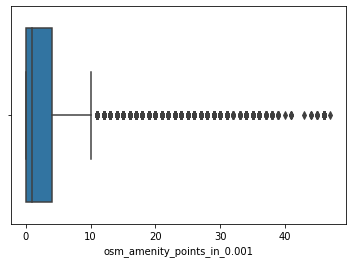

In [2726]:
sns.boxplot(data[full_cols[4]])
detect_outlires(data[full_cols[4]])

In [2727]:
def log_col(col, num=1):
    data[col] = np.log(data[col]+num)
    sns.distplot(data[col])
    detect_outlires(data[col])

osm_amenity_points_in_0.001
IQR = 1.6094379124341003
Нижняя граница: -2.4141568686511503
Верхняя граница: 4.023594781085251
Число выбросов: 0


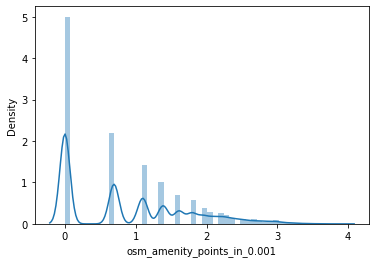

In [2728]:
log_col(full_cols[4])

#### osm_amenity_points_in_0.005

In [2729]:
data[full_cols[5]].describe()

count    282766.000000
mean         40.773604
std          53.654923
min           0.000000
25%           8.000000
50%          22.000000
75%          51.000000
max         468.000000
Name: osm_amenity_points_in_0.005, dtype: float64

osm_amenity_points_in_0.005
IQR = 43.0
Нижняя граница: -56.5
Верхняя граница: 115.5
Число выбросов: 23290


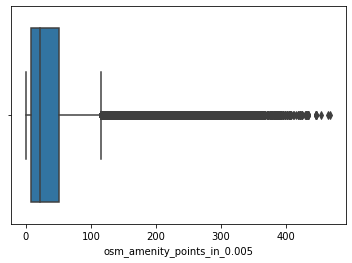

In [2730]:
sns.boxplot(data[full_cols[5]])
detect_outlires(data[full_cols[5]])

osm_amenity_points_in_0.005
IQR = 1.754019141245208
Нижняя граница: -0.4338041345315924
Верхняя граница: 6.5822724304492395
Число выбросов: 0


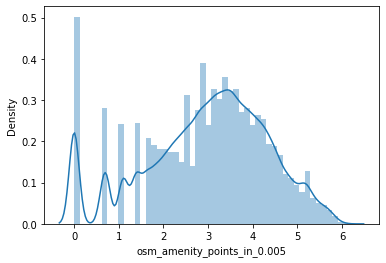

In [2731]:
log_col(full_cols[5])

#### osm_amenity_points_in_0.0075

In [2732]:
data[full_cols[6]].describe()

count    282766.000000
mean         81.961590
std         106.056375
min           0.000000
25%          17.000000
50%          47.000000
75%         101.000000
max         855.000000
Name: osm_amenity_points_in_0.0075, dtype: float64

osm_amenity_points_in_0.0075
IQR = 84.0
Нижняя граница: -109.0
Верхняя граница: 227.0
Число выбросов: 23887


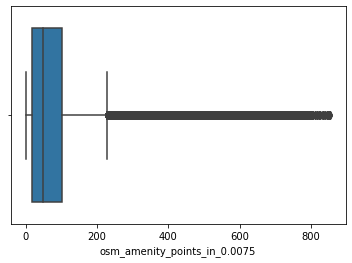

In [2733]:
sns.boxplot(data[full_cols[6]])
detect_outlires(data[full_cols[6]])

osm_amenity_points_in_0.0075
IQR = 1.4136933353080048
Нижняя граница: 1.175296863042322
Верхняя граница: 6.830070204274341
Число выбросов: 0


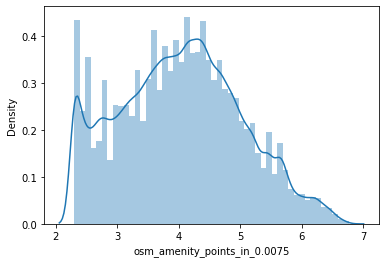

In [2734]:
log_col(full_cols[6], 10)

#### osm_amenity_points_in_0.01

In [2735]:
data[full_cols[7]].describe()

count    282766.000000
mean        133.862823
std         173.666206
min           0.000000
25%          28.000000
50%          78.000000
75%         165.000000
max        1392.000000
Name: osm_amenity_points_in_0.01, dtype: float64

osm_amenity_points_in_0.01
IQR = 137.0
Нижняя граница: -177.5
Верхняя граница: 370.5
Число выбросов: 22700


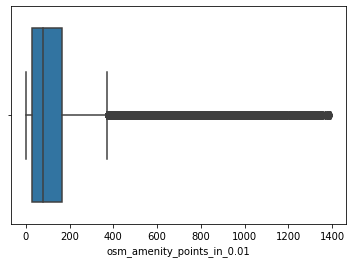

In [2736]:
sns.boxplot(data[full_cols[7]])
detect_outlires(data[full_cols[7]])

osm_amenity_points_in_0.01
IQR = 1.5271998141971288
Нижняя граница: 1.3467864384306925
Верхняя граница: 7.455585695219208
Число выбросов: 0


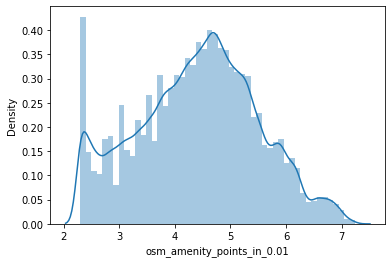

In [2737]:
log_col(full_cols[7], 10)

#### osm_building_points_in_0.001

In [2738]:
data[full_cols[8]].describe()

count    282766.000000
mean          0.037352
std           0.389578
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: osm_building_points_in_0.001, dtype: float64

osm_building_points_in_0.001
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 6381


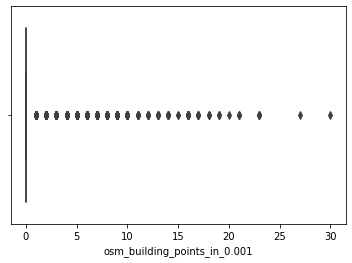

In [2739]:
sns.boxplot(data[full_cols[8]])
detect_outlires(data[full_cols[8]])

In [2740]:
data.drop('osm_building_points_in_0.001', axis=1, inplace=True)

#### osm_building_points_in_0.005

In [2741]:
data[full_cols[9]].describe()

count    282766.000000
mean          0.881089
std           6.826550
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         586.000000
Name: osm_building_points_in_0.005, dtype: float64

osm_building_points_in_0.005
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 60067


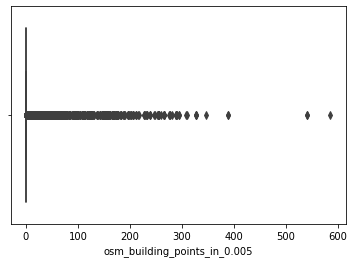

In [2742]:
sns.boxplot(data[full_cols[9]])
detect_outlires(data[full_cols[9]])

In [2743]:
data.drop('osm_building_points_in_0.005', axis=1, inplace=True)

#### osm_building_points_in_0.0075

In [2744]:
data[full_cols[10]].describe()

count    282766.000000
mean          2.034926
std          14.734107
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         949.000000
Name: osm_building_points_in_0.0075, dtype: float64

osm_building_points_in_0.0075
IQR = 1.0
Нижняя граница: -2.0
Верхняя граница: 3.0
Число выбросов: 29888


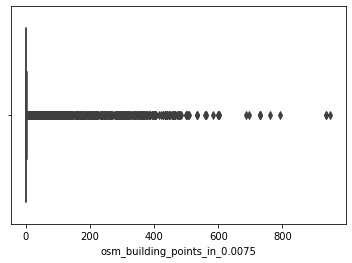

In [2745]:
sns.boxplot(data[full_cols[10]])
detect_outlires(data[full_cols[10]], 2)

osm_building_points_in_0.0075
IQR = 0.6931471805599453
Нижняя граница: -1.0397207708399179
Верхняя граница: 1.732867951399863
Число выбросов: 22466


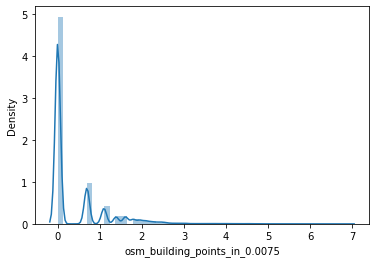

In [2746]:
log_col(full_cols[10], 1)

osm_building_points_in_0.0075
IQR = 0.5265890341390446
Нижняя граница: -0.7898835512085669
Верхняя граница: 1.3164725853476114
Число выбросов: 4809


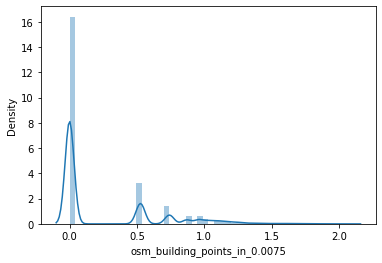

In [2747]:
log_col(full_cols[10], 1)

osm_building_points_in_0.0075
IQR = 0.423035857164402
Нижняя граница: -0.634553785746603
Верхняя граница: 1.057589642911005
Число выбросов: 269


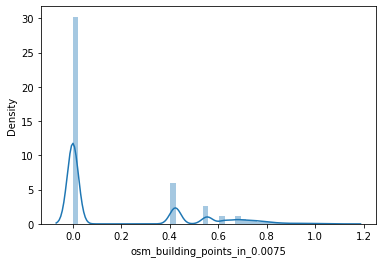

In [2748]:
log_col(full_cols[10], 1)

osm_building_points_in_0.0075
IQR = 0.35279251707864995
Нижняя граница: -0.529188775617975
Верхняя граница: 0.8819812926966248
Число выбросов: 0


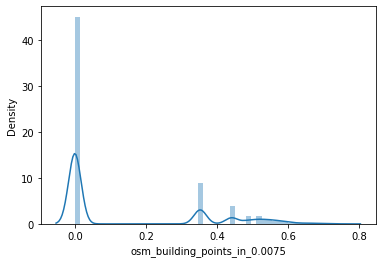

In [2749]:
log_col(full_cols[10], 1)

#### osm_building_points_in_0.01

In [2750]:
data[full_cols[11]].describe()

count    282766.000000
mean          3.725607
std          25.565501
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max        1162.000000
Name: osm_building_points_in_0.01, dtype: float64

osm_building_points_in_0.01
IQR = 2.0
Нижняя граница: -3.0
Верхняя граница: 5.0
Число выбросов: 30739


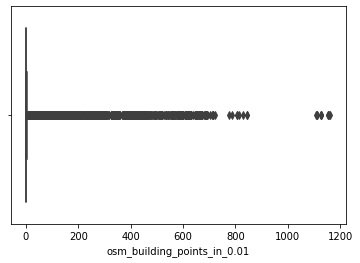

In [2751]:
sns.boxplot(data[full_cols[11]])
detect_outlires(data[full_cols[11]])

osm_building_points_in_0.01
IQR = 1.0986122886681098
Нижняя граница: -1.6479184330021646
Верхняя граница: 2.7465307216702746
Число выбросов: 8387


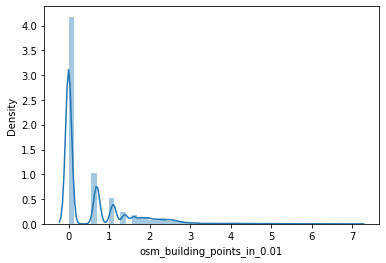

In [2752]:
log_col(full_cols[11], 1)

osm_building_points_in_0.01
IQR = 0.7412763113750154
Нижняя граница: -1.111914467062523
Верхняя граница: 1.8531907784375383
Число выбросов: 777


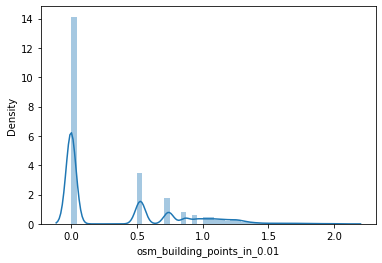

In [2753]:
log_col(full_cols[11], 1)

osm_building_points_in_0.01
IQR = 0.5546183566222742
Нижняя граница: -0.8319275349334113
Верхняя граница: 1.3865458915556856
Число выбросов: 0


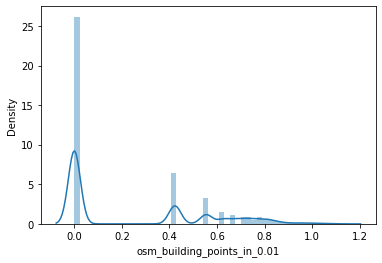

In [2754]:
log_col(full_cols[11], 1)

#### osm_catering_points_in_0.001

In [2755]:
data[full_cols[12]].describe()

count    282766.000000
mean          0.617274
std           1.699532
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.000000
Name: osm_catering_points_in_0.001, dtype: float64

osm_catering_points_in_0.001
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 69508


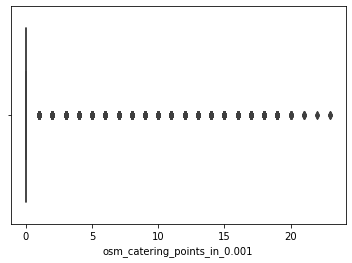

In [2756]:
sns.boxplot(data[full_cols[12]])
detect_outlires(data[full_cols[12]])

osm_catering_points_in_0.001
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 69508


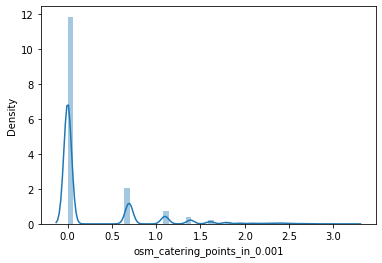

In [2757]:
log_col(full_cols[12], 1)

In [2758]:
data.drop('osm_catering_points_in_0.001', axis=1, inplace=True)

#### osm_catering_points_in_0.005

In [2759]:
data[full_cols[13]].describe()

count    282766.000000
mean          8.869316
std          17.889184
min           0.000000
25%           0.000000
50%           2.000000
75%           8.000000
max         169.000000
Name: osm_catering_points_in_0.005, dtype: float64

osm_catering_points_in_0.005
IQR = 8.0
Нижняя граница: -12.0
Верхняя граница: 20.0
Число выбросов: 32467


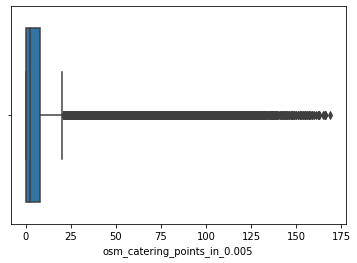

In [2760]:
sns.boxplot(data[full_cols[13]])
detect_outlires(data[full_cols[13]])

osm_catering_points_in_0.005
IQR = 2.1972245773362196
Нижняя граница: -3.295836866004329
Верхняя граница: 5.493061443340549
Число выбросов: 0


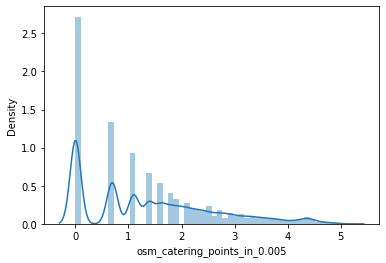

In [2761]:
log_col(full_cols[13])

#### osm_catering_points_in_0.0075

In [2762]:
data[full_cols[14]].describe()

count    282766.000000
mean         17.535358
std          33.702699
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max         323.000000
Name: osm_catering_points_in_0.0075, dtype: float64

osm_catering_points_in_0.0075
IQR = 15.0
Нижняя граница: -21.5
Верхняя граница: 38.5
Число выбросов: 35794


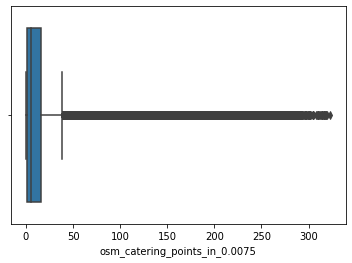

In [2763]:
sns.boxplot(data[full_cols[14]])
detect_outlires(data[full_cols[14]])

osm_catering_points_in_0.0075
IQR = 2.1400661634962708
Нижняя граница: -2.5169520646844608
Верхняя граница: 6.043312589300623
Число выбросов: 0


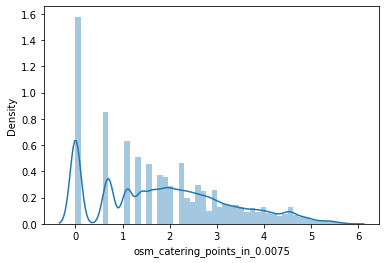

In [2764]:
log_col(full_cols[14])

#### osm_catering_points_in_0.01

In [2765]:
data[full_cols[15]].describe()

count    282766.000000
mean         28.537809
std          54.474599
min           0.000000
25%           2.000000
50%           9.000000
75%          26.000000
max         519.000000
Name: osm_catering_points_in_0.01, dtype: float64

osm_catering_points_in_0.01
IQR = 24.0
Нижняя граница: -34.0
Верхняя граница: 62.0
Число выбросов: 35250


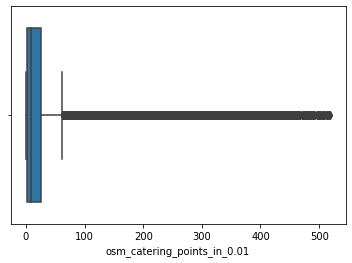

In [2766]:
sns.boxplot(data[full_cols[15]])
detect_outlires(data[full_cols[15]])

osm_catering_points_in_0.01
IQR = 2.197224577336219
Нижняя граница: -2.197224577336219
Верхняя граница: 6.591673732008658
Число выбросов: 0


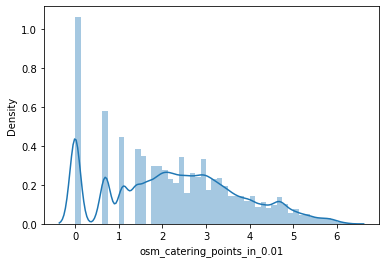

In [2767]:
log_col(full_cols[15])

#### osm_city_closest_dist

In [2768]:
data[full_cols[16]].describe()

count    282766.000000
mean         15.449539
std          34.735964
min           0.000802
25%           2.531062
50%           5.287790
75%          10.694227
max        1107.810806
Name: osm_city_closest_dist, dtype: float64

osm_city_closest_dist
IQR = 8.163165561194788
Нижняя граница: -9.713686482195445
Верхняя граница: 22.938975762583706
Число выбросов: 36708


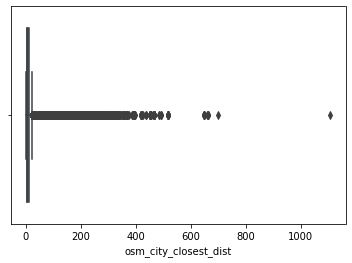

In [2769]:
sns.boxplot(data[full_cols[16]])
detect_outlires(data[full_cols[16]])

osm_city_closest_dist
IQR = 1.1069328475561722
Нижняя граница: -0.266369441357994
Верхняя граница: 4.161361948866695
Число выбросов: 18357


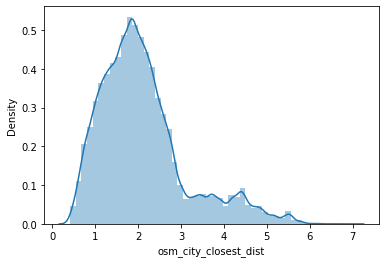

In [2770]:
log_col(full_cols[16], 1.5)

osm_city_closest_dist
IQR = 0.32388506586704335
Нижняя граница: 0.5768223368791613
Верхняя граница: 1.8723626003473348
Число выбросов: 4333


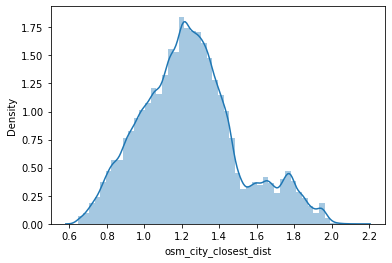

In [2771]:
log_col(full_cols[16], 1.5)

In [2772]:
data[full_cols[16]] = data[full_cols[16]].apply(
    lambda x: 1.8 if x > 1.8 else x)

In [2773]:
detect_outlires(data[full_cols[16]])

osm_city_closest_dist
IQR = 0.32388506586704335
Нижняя граница: 0.5768223368791613
Верхняя граница: 1.8723626003473348
Число выбросов: 0


#### osm_city_nearest_name

Обработаем признак по аналогии с городом и посмотрим на уникальные

In [2774]:
data[full_cols[17]]

0                 Пермь
1         Орехово-Зуево
2             Ярославль
3           Новокузнецк
4                 Химки
             ...       
2969         Красноярск
2970              Томск
2971             Калуга
2972    Нижний Новгород
2973    Нижний Новгород
Name: osm_city_nearest_name, Length: 282766, dtype: object

In [2775]:
data[full_cols[17]] = data[full_cols[17]].apply(lambda x: x.lower())

In [2776]:
data[full_cols[17]].nunique()

170

#### osm_crossing_closest_dist

In [2777]:
data[full_cols[18]].describe()

count    282766.000000
mean          0.515647
std           3.991018
min           0.000223
25%           0.071410
50%           0.135335
75%           0.273919
max        1072.660533
Name: osm_crossing_closest_dist, dtype: float64

osm_crossing_closest_dist
IQR = 0.2025089609643816
Нижняя граница: -0.23235367624247333
Верхняя граница: 0.5776821676150531
Число выбросов: 30300


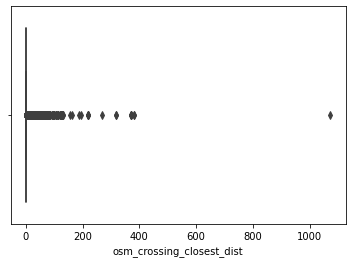

In [2778]:
sns.boxplot(data[full_cols[18]])
detect_outlires(data[full_cols[18]])

In [2779]:
data.drop('osm_crossing_closest_dist', axis=1, inplace=True)

#### osm_crossing_points_in_0.001

In [2780]:
data[full_cols[19]].describe()

count    282766.000000
mean          0.739658
std           1.388600
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: osm_crossing_points_in_0.001, dtype: float64

osm_crossing_points_in_0.001
IQR = 1.0
Нижняя граница: -1.5
Верхняя граница: 2.5
Число выбросов: 31117


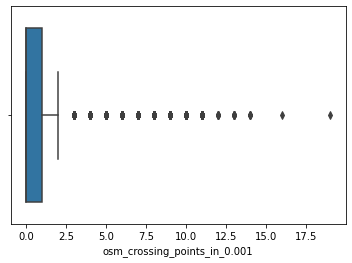

In [2781]:
sns.boxplot(data[full_cols[19]])
detect_outlires(data[full_cols[19]])

osm_crossing_points_in_0.001
IQR = 0.6931471805599453
Нижняя граница: -1.0397207708399179
Верхняя граница: 1.732867951399863
Число выбросов: 8038


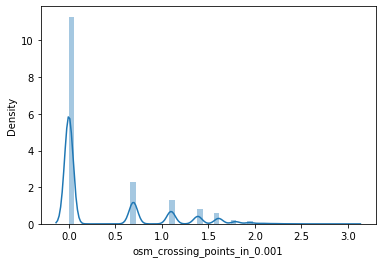

In [2782]:
log_col(full_cols[19])

osm_crossing_points_in_0.001
IQR = 0.5265890341390446
Нижняя граница: -0.7898835512085669
Верхняя граница: 1.3164725853476114
Число выбросов: 2


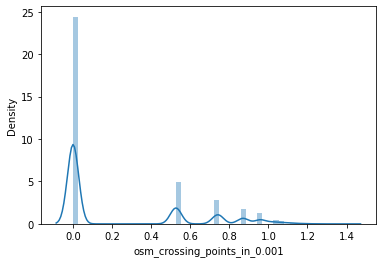

In [2783]:
log_col(full_cols[19])

In [2784]:
data[full_cols[19]] = data[full_cols[19]].apply(
    lambda x: 1.3 if x > 1.3 else x)

#### osm_crossing_points_in_0.005

In [2785]:
data[full_cols[20]].describe()

count    282766.000000
mean         14.132622
std          15.131817
min           0.000000
25%           3.000000
50%          10.000000
75%          20.000000
max         135.000000
Name: osm_crossing_points_in_0.005, dtype: float64

osm_crossing_points_in_0.005
IQR = 17.0
Нижняя граница: -22.5
Верхняя граница: 45.5
Число выбросов: 14316


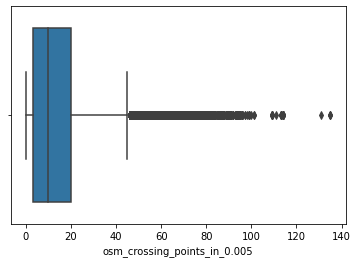

In [2786]:
sns.boxplot(data[full_cols[20]])
detect_outlires(data[full_cols[20]])

osm_crossing_points_in_0.005
IQR = 1.6582280766035324
Нижняя граница: -1.101047753785408
Верхняя граница: 5.531864552628722
Число выбросов: 0


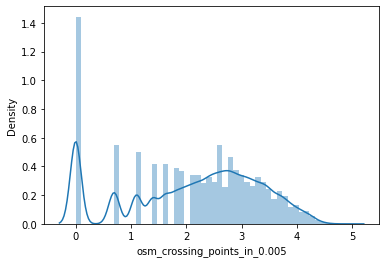

In [2787]:
log_col(full_cols[20])

#### osm_crossing_points_in_0.0075

In [2788]:
data[full_cols[21]].describe()

count    282766.000000
mean         29.379788
std          30.220676
min           0.000000
25%           7.000000
50%          21.000000
75%          41.000000
max         198.000000
Name: osm_crossing_points_in_0.0075, dtype: float64

osm_crossing_points_in_0.0075
IQR = 34.0
Нижняя граница: -44.0
Верхняя граница: 92.0
Число выбросов: 14598


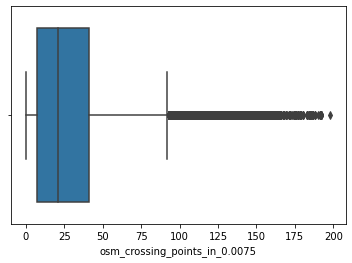

In [2789]:
sns.boxplot(data[full_cols[21]])
detect_outlires(data[full_cols[21]])

osm_crossing_points_in_0.0075
IQR = 1.6582280766035327
Нижняя граница: -0.40790057322546325
Верхняя граница: 6.225011733188667
Число выбросов: 0


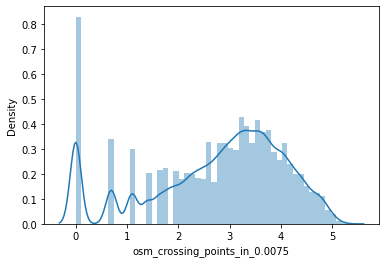

In [2790]:
log_col(full_cols[21], 1)

#### osm_crossing_points_in_0.01

In [2791]:
data[full_cols[22]].describe()

count    282766.000000
mean         48.828335
std          49.225979
min           0.000000
25%          12.000000
50%          35.000000
75%          68.000000
max         267.000000
Name: osm_crossing_points_in_0.01, dtype: float64

osm_crossing_points_in_0.01
IQR = 56.0
Нижняя граница: -72.0
Верхняя граница: 152.0
Число выбросов: 15317


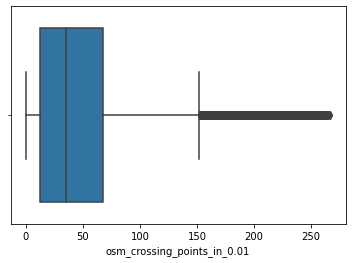

In [2792]:
sns.boxplot(data[full_cols[22]])
detect_outlires(data[full_cols[22]])

osm_crossing_points_in_0.01
IQR = 1.4572460970921748
Нижняя граница: 0.647344198417954
Верхняя граница: 6.476328586786654
Число выбросов: 0


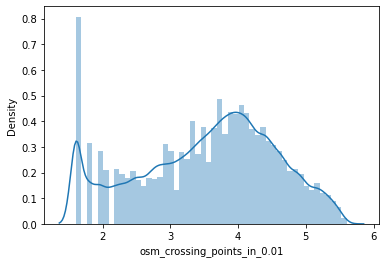

In [2793]:
log_col(full_cols[22], 5)

#### osm_culture_points_in_0.001

In [2794]:
data[full_cols[23]].describe()

count    282766.000000
mean          0.072261
std           0.374295
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: osm_culture_points_in_0.001, dtype: float64

osm_culture_points_in_0.001
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 14737


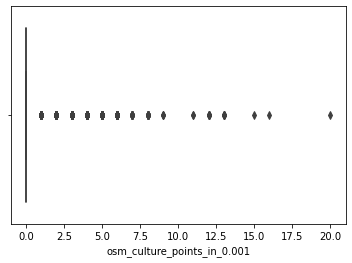

In [2795]:
sns.boxplot(data[full_cols[23]])
detect_outlires(data[full_cols[23]])

In [2796]:
data.drop('osm_culture_points_in_0.001', axis=1, inplace=True)

#### osm_culture_points_in_0.005

In [2797]:
data[full_cols[24]].describe()

count    282766.000000
mean          1.495307
std           4.422877
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         162.000000
Name: osm_culture_points_in_0.005, dtype: float64

osm_culture_points_in_0.005
IQR = 1.0
Нижняя граница: -1.5
Верхняя граница: 2.5
Число выбросов: 42781


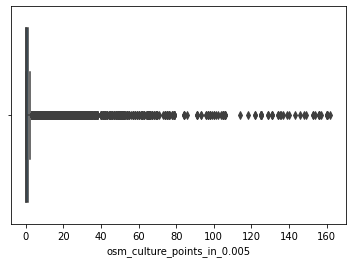

In [2798]:
sns.boxplot(data[full_cols[24]])
detect_outlires(data[full_cols[24]])

In [2799]:
data.drop('osm_culture_points_in_0.005', axis=1, inplace=True)

#### osm_culture_points_in_0.0075

In [2800]:
data[full_cols[25]].describe()

count    282766.000000
mean          3.274294
std           8.843791
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         265.000000
Name: osm_culture_points_in_0.0075, dtype: float64

osm_culture_points_in_0.0075
IQR = 2.0
Нижняя граница: -3.0
Верхняя граница: 5.0
Число выбросов: 43313


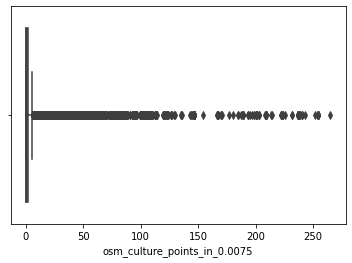

In [2801]:
sns.boxplot(data[full_cols[25]])
detect_outlires(data[full_cols[25]])

In [2802]:
data.drop('osm_culture_points_in_0.0075', axis=1, inplace=True)

#### osm_culture_points_in_0.01

In [2803]:
data[full_cols[26]].describe()

count    282766.000000
mean          5.580957
std          14.032416
min           0.000000
25%           0.000000
50%           1.000000
75%           5.000000
max         336.000000
Name: osm_culture_points_in_0.01, dtype: float64

osm_culture_points_in_0.01
IQR = 5.0
Нижняя граница: -7.5
Верхняя граница: 12.5
Число выбросов: 34597


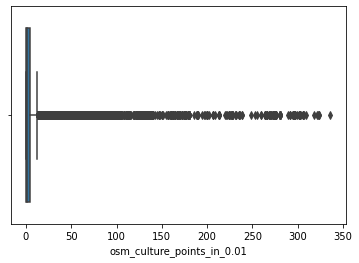

In [2804]:
sns.boxplot(data[full_cols[26]])
detect_outlires(data[full_cols[26]])

osm_culture_points_in_0.01
IQR = 2.8716796248840124
Нижняя граница: -5.511492241651954
Верхняя граница: 5.975226257884094
Число выбросов: 0


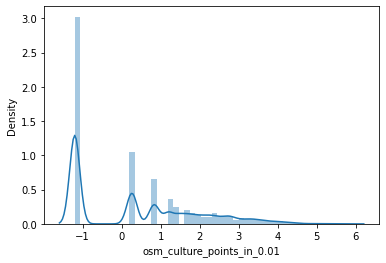

In [2805]:
log_col(full_cols[26], 0.3)

#### osm_finance_points_in_0.001

In [2806]:
data[full_cols[27]].describe()

count    282766.000000
mean          0.146694
std           0.459254
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: osm_finance_points_in_0.001, dtype: float64

osm_finance_points_in_0.001
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 32529


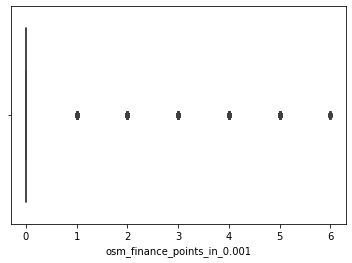

In [2807]:
sns.boxplot(data[full_cols[27]])
detect_outlires(data[full_cols[27]])

In [2808]:
data.drop('osm_finance_points_in_0.001', axis=1, inplace=True)

#### osm_finance_points_in_0.005

In [2809]:
data[full_cols[28]].describe()

count    282766.000000
mean          2.059710
std           3.376286
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          28.000000
Name: osm_finance_points_in_0.005, dtype: float64

osm_finance_points_in_0.005
IQR = 3.0
Нижняя граница: -4.5
Верхняя граница: 7.5
Число выбросов: 23482


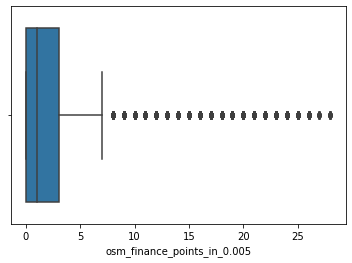

In [2810]:
sns.boxplot(data[full_cols[28]])
detect_outlires(data[full_cols[28]])

osm_finance_points_in_0.005
IQR = 1.3862943611198906
Нижняя граница: -2.0794415416798357
Верхняя граница: 3.465735902799726
Число выбросов: 0


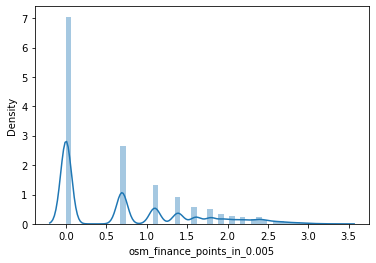

In [2811]:
log_col(full_cols[28])

#### osm_finance_points_in_0.0075

In [2812]:
data[full_cols[29]].describe()

count    282766.000000
mean          4.060142
std           6.122168
min           0.000000
25%           0.000000
50%           1.000000
75%           5.000000
max          42.000000
Name: osm_finance_points_in_0.0075, dtype: float64

osm_finance_points_in_0.0075
IQR = 5.0
Нижняя граница: -7.5
Верхняя граница: 12.5
Число выбросов: 27083


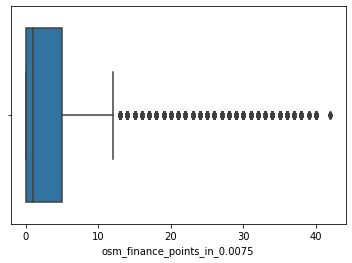

In [2813]:
sns.boxplot(data[full_cols[29]])
detect_outlires(data[full_cols[29]])

osm_finance_points_in_0.0075
IQR = 1.791759469228055
Нижняя граница: -2.6876392038420827
Верхняя граница: 4.479398673070138
Число выбросов: 0


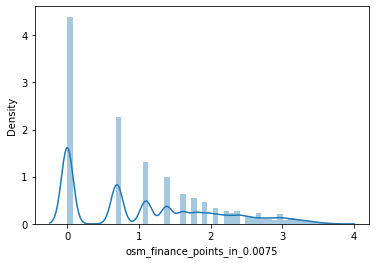

In [2814]:
log_col(full_cols[29])

#### osm_finance_points_in_0.01

In [2815]:
data[full_cols[30]].describe()

count    282766.000000
mean          6.472486
std           9.369221
min           0.000000
25%           1.000000
50%           3.000000
75%           8.000000
max          60.000000
Name: osm_finance_points_in_0.01, dtype: float64

osm_finance_points_in_0.01
IQR = 7.0
Нижняя граница: -9.5
Верхняя граница: 18.5
Число выбросов: 29508


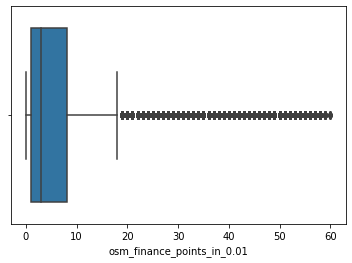

In [2816]:
sns.boxplot(data[full_cols[30]])
detect_outlires(data[full_cols[30]])

osm_finance_points_in_0.01
IQR = 1.5040773967762742
Нижняя граница: -1.5629689146044656
Верхняя граница: 4.45334067250063
Число выбросов: 0


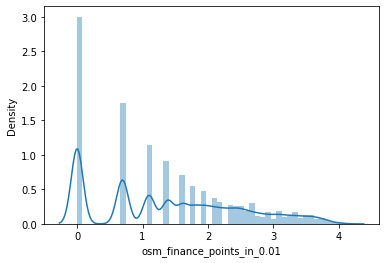

In [2817]:
log_col(full_cols[30])

#### osm_healthcare_points_in_0.005

In [2818]:
data[full_cols[31]].describe()

count    282766.000000
mean          2.035535
std           3.338859
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          30.000000
Name: osm_healthcare_points_in_0.005, dtype: float64

osm_healthcare_points_in_0.005
IQR = 3.0
Нижняя граница: -4.5
Верхняя граница: 7.5
Число выбросов: 18001


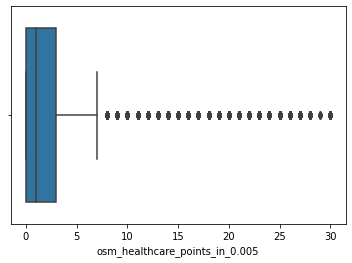

In [2819]:
sns.boxplot(data[full_cols[31]])
detect_outlires(data[full_cols[31]])

osm_healthcare_points_in_0.005
IQR = 1.3862943611198906
Нижняя граница: -2.0794415416798357
Верхняя граница: 3.465735902799726
Число выбросов: 0


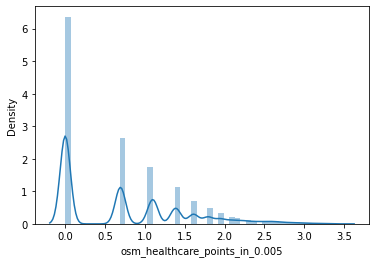

In [2820]:
log_col(full_cols[31])

#### osm_healthcare_points_in_0.0075

In [2821]:
data[full_cols[32]].describe()

count    282766.000000
mean          4.164097
std           6.444692
min           0.000000
25%           0.000000
50%           2.000000
75%           5.000000
max          56.000000
Name: osm_healthcare_points_in_0.0075, dtype: float64

osm_healthcare_points_in_0.0075
IQR = 5.0
Нижняя граница: -7.5
Верхняя граница: 12.5
Число выбросов: 22196


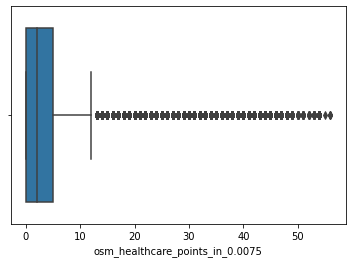

In [2822]:
sns.boxplot(data[full_cols[32]])
detect_outlires(data[full_cols[32]])

osm_healthcare_points_in_0.0075
IQR = 1.791759469228055
Нижняя граница: -2.6876392038420827
Верхняя граница: 4.479398673070138
Число выбросов: 0


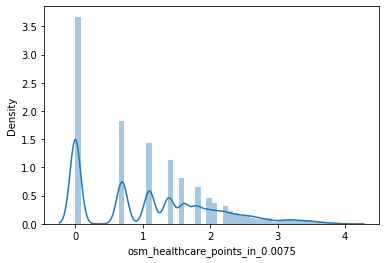

In [2823]:
log_col(full_cols[32])

#### osm_healthcare_points_in_0.01

In [2824]:
data[full_cols[33]].describe()

count    282766.000000
mean          6.853876
std          10.363146
min           0.000000
25%           1.000000
50%           3.000000
75%           8.000000
max          78.000000
Name: osm_healthcare_points_in_0.01, dtype: float64

osm_healthcare_points_in_0.01
IQR = 7.0
Нижняя граница: -9.5
Верхняя граница: 18.5
Число выбросов: 25164


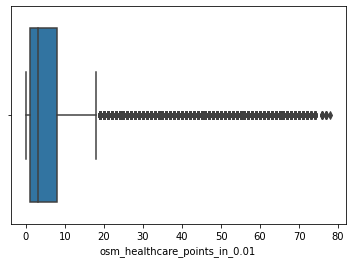

In [2825]:
sns.boxplot(data[full_cols[33]])
detect_outlires(data[full_cols[33]])

osm_healthcare_points_in_0.01
IQR = 1.5040773967762742
Нижняя граница: -1.5629689146044656
Верхняя граница: 4.45334067250063
Число выбросов: 0


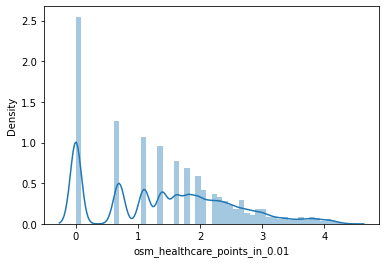

In [2826]:
log_col(full_cols[33])

#### osm_historic_points_in_0.005

In [2827]:
data[full_cols[34]].describe()

count    282766.000000
mean          1.686119
std           3.908408
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          53.000000
Name: osm_historic_points_in_0.005, dtype: float64

osm_historic_points_in_0.005
IQR = 2.0
Нижняя граница: -3.0
Верхняя граница: 5.0
Число выбросов: 24143


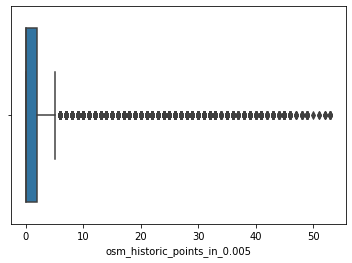

In [2828]:
sns.boxplot(data[full_cols[34]])
detect_outlires(data[full_cols[34]])

osm_historic_points_in_0.005
IQR = 2.3978952727983707
Нижняя граница: -5.2062808216316565
Верхняя граница: 4.385300269561826
Число выбросов: 0


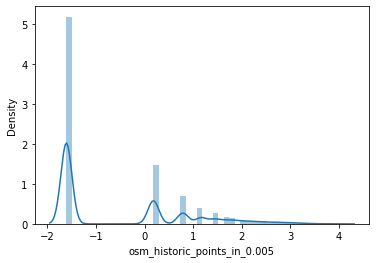

In [2829]:
log_col(full_cols[34], 0.2)

#### osm_historic_points_in_0.0075

In [2830]:
data[full_cols[35]].describe()

count    282766.000000
mean          3.690048
std           7.819978
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max          89.000000
Name: osm_historic_points_in_0.0075, dtype: float64

osm_historic_points_in_0.0075
IQR = 4.0
Нижняя граница: -6.0
Верхняя граница: 10.0
Число выбросов: 26231


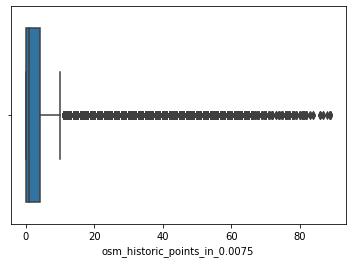

In [2831]:
sns.boxplot(data[full_cols[35]])
detect_outlires(data[full_cols[35]])

osm_historic_points_in_0.0075
IQR = 2.1972245773362196
Нижняя граница: -3.9889840465642745
Верхняя граница: 4.799914262780604
Число выбросов: 0


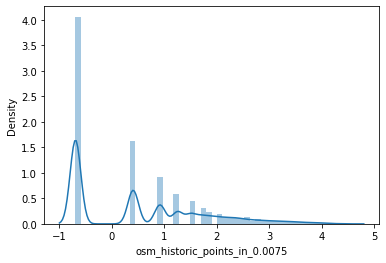

In [2832]:
log_col(full_cols[35], 0.5)

#### osm_historic_points_in_0.01

In [2833]:
data[full_cols[36]].describe()

count    282766.000000
mean          6.243965
std          12.733504
min           0.000000
25%           0.000000
50%           2.000000
75%           6.000000
max         129.000000
Name: osm_historic_points_in_0.01, dtype: float64

osm_historic_points_in_0.01
IQR = 6.0
Нижняя граница: -9.0
Верхняя граница: 15.0
Число выбросов: 30145


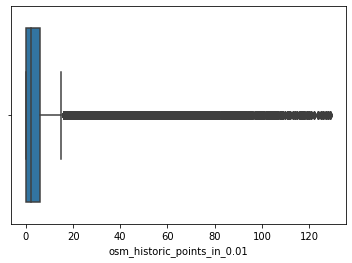

In [2834]:
sns.boxplot(data[full_cols[36]])
detect_outlires(data[full_cols[36]])

osm_historic_points_in_0.01
IQR = 1.9459101490553132
Нижняя граница: -2.9188652235829697
Верхняя граница: 4.864775372638283
Число выбросов: 7


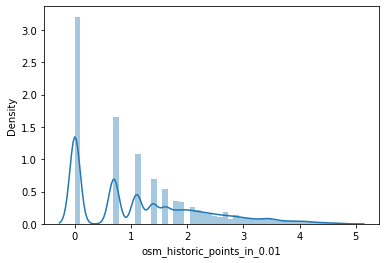

In [2835]:
log_col(full_cols[36])

In [2836]:
data[full_cols[36]] = data[full_cols[36]].apply(
    lambda x: 4.86 if x > 4.86 else x)

#### osm_hotels_points_in_0.005

In [2837]:
data[full_cols[37]].describe()

count    282766.000000
mean          1.061758
std           3.426329
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          80.000000
Name: osm_hotels_points_in_0.005, dtype: float64

osm_hotels_points_in_0.005
IQR = 1.0
Нижняя граница: -1.5
Верхняя граница: 2.5
Число выбросов: 28620


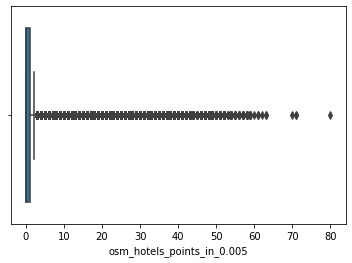

In [2838]:
sns.boxplot(data[full_cols[37]])
detect_outlires(data[full_cols[37]])

In [2839]:
data.drop('osm_hotels_points_in_0.005', axis=1, inplace=True)

#### osm_hotels_points_in_0.0075

In [2840]:
data[full_cols[38]].describe()

count    282766.000000
mean          2.182854
std           6.659729
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         113.000000
Name: osm_hotels_points_in_0.0075, dtype: float64

osm_hotels_points_in_0.0075
IQR = 2.0
Нижняя граница: -3.0
Верхняя граница: 5.0
Число выбросов: 26491


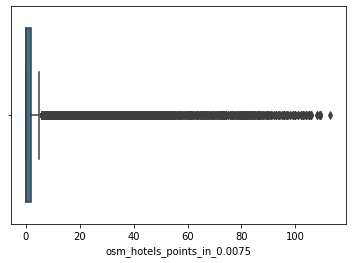

In [2841]:
sns.boxplot(data[full_cols[38]])
detect_outlires(data[full_cols[38]])

In [2842]:
data.drop('osm_hotels_points_in_0.0075', axis=1, inplace=True)

#### osm_hotels_points_in_0.01

In [2843]:
data[full_cols[39]].describe()

count    282766.000000
mean          3.617518
std          10.712659
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max         159.000000
Name: osm_hotels_points_in_0.01, dtype: float64

osm_hotels_points_in_0.01
IQR = 3.0
Нижняя граница: -4.5
Верхняя граница: 7.5
Число выбросов: 30226


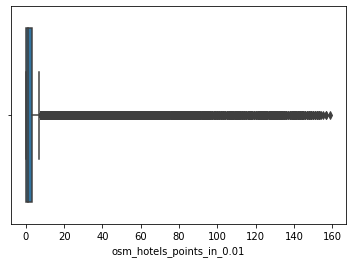

In [2844]:
sns.boxplot(data[full_cols[39]])
detect_outlires(data[full_cols[39]])

osm_hotels_points_in_0.01
IQR = 2.772588722239781
Нижняя граница: -5.768320995793772
Верхняя граница: 5.322033893165353
Число выбросов: 0


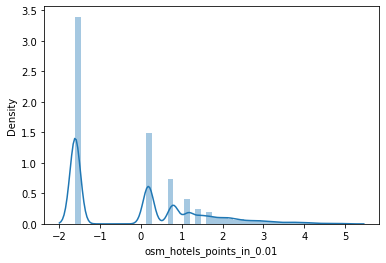

In [2845]:
log_col(full_cols[39], 0.2)

#### osm_leisure_points_in_0.005

In [2846]:
data[full_cols[40]].describe()

count    282766.000000
mean          2.023624
std           3.045143
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          35.000000
Name: osm_leisure_points_in_0.005, dtype: float64

osm_leisure_points_in_0.005
IQR = 3.0
Нижняя граница: -4.5
Верхняя граница: 7.5
Число выбросов: 18196


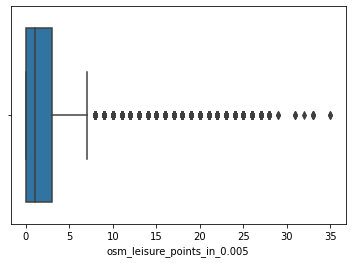

In [2847]:
sns.boxplot(data[full_cols[40]])
detect_outlires(data[full_cols[40]])

osm_leisure_points_in_0.005
IQR = 1.3862943611198906
Нижняя граница: -2.0794415416798357
Верхняя граница: 3.465735902799726
Число выбросов: 11


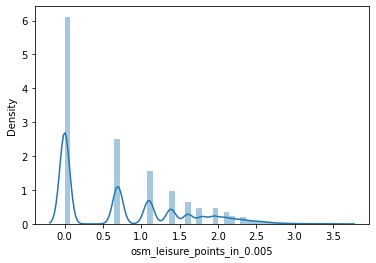

In [2848]:
log_col(full_cols[40])

In [2849]:
data[full_cols[40]] = data[full_cols[40]].apply(
    lambda x: 3.46 if x > 3.46 else x)

#### osm_leisure_points_in_0.0075

In [2850]:
data[full_cols[41]].describe()

count    282766.000000
mean          4.190925
std           5.694128
min           0.000000
25%           0.000000
50%           2.000000
75%           6.000000
max          75.000000
Name: osm_leisure_points_in_0.0075, dtype: float64

osm_leisure_points_in_0.0075
IQR = 6.0
Нижняя граница: -9.0
Верхняя граница: 15.0
Число выбросов: 16419


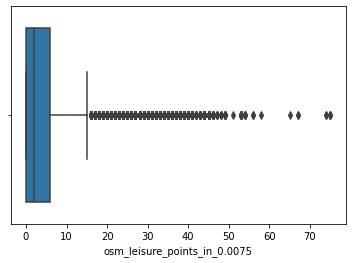

In [2851]:
sns.boxplot(data[full_cols[41]])
detect_outlires(data[full_cols[41]])

osm_leisure_points_in_0.0075
IQR = 1.9459101490553132
Нижняя граница: -2.9188652235829697
Верхняя граница: 4.864775372638283
Число выбросов: 0


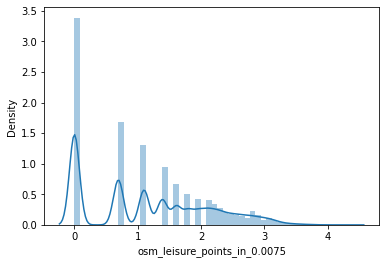

In [2852]:
log_col(full_cols[41])

#### osm_leisure_points_in_0.01

In [2853]:
data[full_cols[42]].describe()

count    282766.000000
mean          7.052248
std           9.106828
min           0.000000
25%           1.000000
50%           3.000000
75%          10.000000
max         106.000000
Name: osm_leisure_points_in_0.01, dtype: float64

osm_leisure_points_in_0.01
IQR = 9.0
Нижняя граница: -12.5
Верхняя граница: 23.5
Число выбросов: 20790


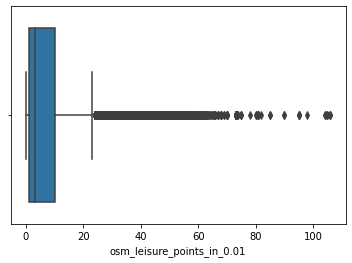

In [2854]:
sns.boxplot(data[full_cols[42]])
detect_outlires(data[full_cols[42]])

osm_leisure_points_in_0.01
IQR = 1.7047480922384253
Нижняя граница: -1.8639749577976925
Верхняя граница: 4.955017411156009
Число выбросов: 0


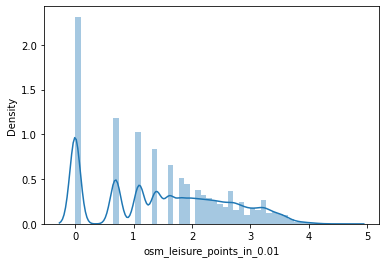

In [2855]:
log_col(full_cols[42])

#### osm_offices_points_in_0.001

In [2856]:
data[full_cols[43]].describe()

count    282766.000000
mean          0.240110
std           0.739648
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          17.000000
Name: osm_offices_points_in_0.001, dtype: float64

osm_offices_points_in_0.001
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 43243


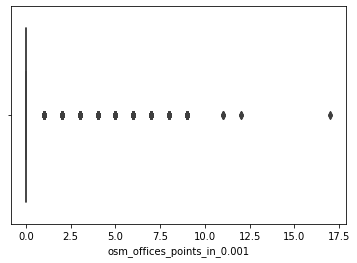

In [2857]:
sns.boxplot(data[full_cols[43]])
detect_outlires(data[full_cols[43]])

In [2858]:
data.drop('osm_offices_points_in_0.001', axis=1, inplace=True)

#### osm_offices_points_in_0.005

In [2859]:
data[full_cols[44]].describe()

count    282766.000000
mean          3.128767
std           5.587255
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max          63.000000
Name: osm_offices_points_in_0.005, dtype: float64

osm_offices_points_in_0.005
IQR = 4.0
Нижняя граница: -6.0
Верхняя граница: 10.0
Число выбросов: 23158


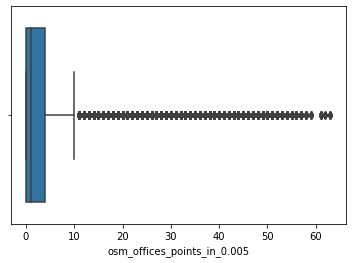

In [2860]:
sns.boxplot(data[full_cols[44]])
detect_outlires(data[full_cols[44]])

osm_offices_points_in_0.005
IQR = 1.6945957207744073
Нижняя граница: -2.6472540968194376
Верхняя граница: 4.131128786278192
Число выбросов: 12


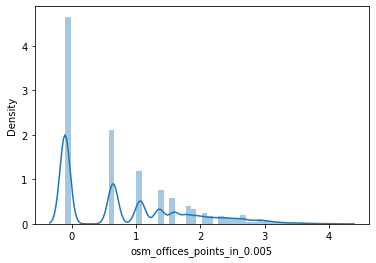

In [2861]:
log_col(full_cols[44], 0.9)

In [2862]:
data[full_cols[44]] = data[full_cols[44]].apply(
    lambda x: 4.13 if x > 4.13 else x)

#### osm_offices_points_in_0.0075

In [2863]:
data[full_cols[45]].describe()

count    282766.000000
mean          6.260141
std          10.885012
min           0.000000
25%           0.000000
50%           2.000000
75%           7.000000
max         127.000000
Name: osm_offices_points_in_0.0075, dtype: float64

osm_offices_points_in_0.0075
IQR = 7.0
Нижняя граница: -10.5
Верхняя граница: 17.5
Число выбросов: 27334


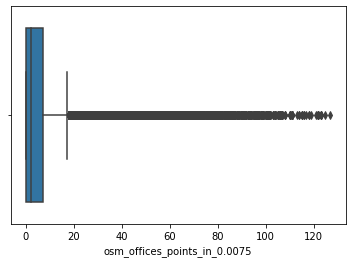

In [2864]:
sns.boxplot(data[full_cols[45]])
detect_outlires(data[full_cols[45]])

osm_offices_points_in_0.0075
IQR = 2.0794415416798357
Нижняя граница: -3.1191623125197534
Верхняя граница: 5.19860385419959
Число выбросов: 0


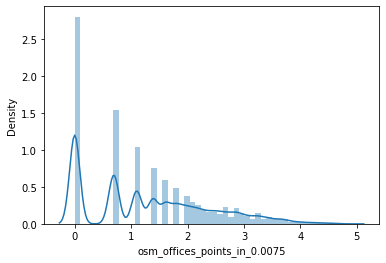

In [2865]:
log_col(full_cols[45])

#### osm_offices_points_in_0.01

In [2866]:
data[full_cols[46]].describe()

count    282766.000000
mean         10.284518
std          17.723148
min           0.000000
25%           1.000000
50%           4.000000
75%          11.000000
max         179.000000
Name: osm_offices_points_in_0.01, dtype: float64

osm_offices_points_in_0.01
IQR = 10.0
Нижняя граница: -14.0
Верхняя граница: 26.0
Число выбросов: 28796


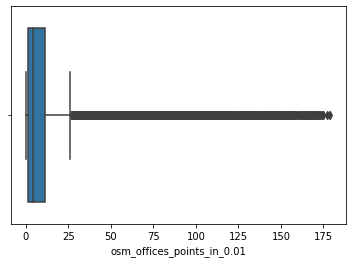

In [2867]:
sns.boxplot(data[full_cols[46]])
detect_outlires(data[full_cols[46]])

osm_offices_points_in_0.01
IQR = 1.791759469228055
Нижняя граница: -1.9944920232821373
Верхняя граница: 5.1725458536300835
Число выбросов: 4


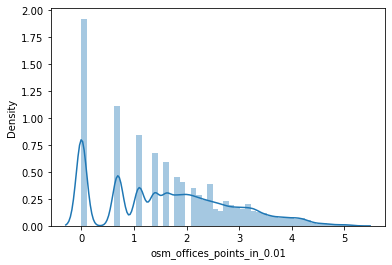

In [2868]:
log_col(full_cols[46])

In [2869]:
data[full_cols[46]] = data[full_cols[46]].apply(
    lambda x: 5.17 if x > 5.17 else x)

#### osm_shops_points_in_0.001

In [2870]:
data[full_cols[47]].describe()

count    282766.000000
mean          1.625248
std           2.668219
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          40.000000
Name: osm_shops_points_in_0.001, dtype: float64

osm_shops_points_in_0.001
IQR = 2.0
Нижняя граница: -3.0
Верхняя граница: 5.0
Число выбросов: 23948


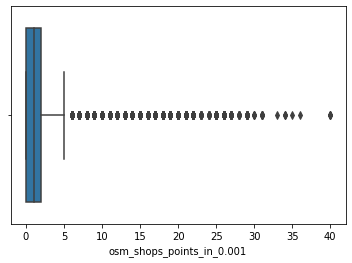

In [2871]:
sns.boxplot(data[full_cols[47]])
detect_outlires(data[full_cols[47]])

osm_shops_points_in_0.001
IQR = 1.791759469228055
Нижняя граница: -3.6039299357162378
Верхняя граница: 3.5631079411959825
Число выбросов: 6


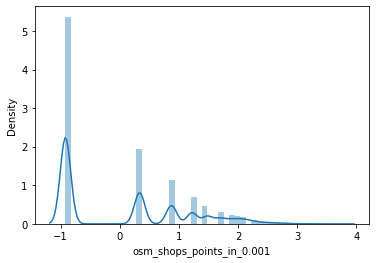

In [2872]:
log_col(full_cols[47], 0.4)

In [2873]:
data[full_cols[47]] = data[full_cols[47]].apply(
    lambda x: 3.56 if x > 3.56 else x)

#### osm_shops_points_in_0.005

In [2874]:
data[full_cols[48]].describe()

count    282766.000000
mean         22.736358
std          28.708830
min           0.000000
25%           4.000000
50%          13.000000
75%          30.000000
max         309.000000
Name: osm_shops_points_in_0.005, dtype: float64

osm_shops_points_in_0.005
IQR = 26.0
Нижняя граница: -35.0
Верхняя граница: 69.0
Число выбросов: 19810


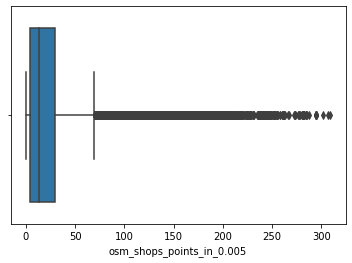

In [2875]:
sns.boxplot(data[full_cols[48]])
detect_outlires(data[full_cols[48]])

osm_shops_points_in_0.005
IQR = 1.824549292051046
Нижняя граница: -1.1273860256424688
Верхняя граница: 6.170811142561716
Число выбросов: 0


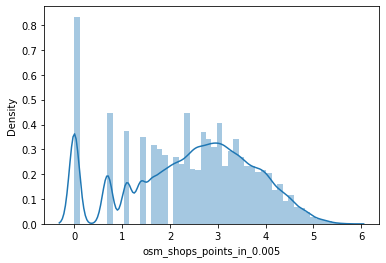

In [2876]:
log_col(full_cols[48])

#### osm_shops_points_in_0.0075

In [2877]:
data[full_cols[49]].describe()

count    282766.000000
mean         45.012049
std          54.805814
min           0.000000
25%           9.000000
50%          27.000000
75%          59.000000
max         515.000000
Name: osm_shops_points_in_0.0075, dtype: float64

osm_shops_points_in_0.0075
IQR = 50.0
Нижняя граница: -66.0
Верхняя граница: 134.0
Число выбросов: 18858


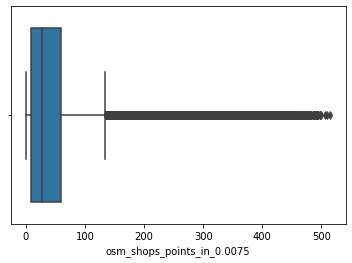

In [2878]:
sns.boxplot(data[full_cols[49]])
detect_outlires(data[full_cols[49]])

osm_shops_points_in_0.0075
IQR = 1.7917594692280545
Нижняя граница: -0.38505411084803587
Верхняя граница: 6.781983766064182
Число выбросов: 0


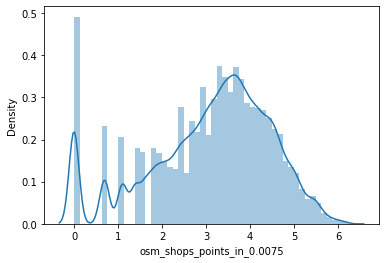

In [2879]:
log_col(full_cols[49])

#### osm_shops_points_in_0.01

In [2880]:
data[full_cols[50]].describe()

count    282766.000000
mean         72.796245
std          87.545510
min           0.000000
25%          16.000000
50%          45.000000
75%          96.000000
max         809.000000
Name: osm_shops_points_in_0.01, dtype: float64

osm_shops_points_in_0.01
IQR = 80.0
Нижняя граница: -104.0
Верхняя граница: 216.0
Число выбросов: 17306


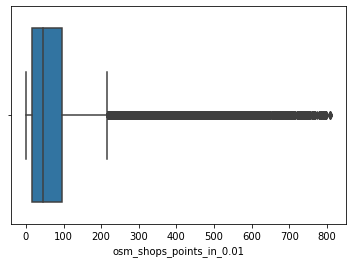

In [2881]:
sns.boxplot(data[full_cols[50]])
detect_outlires(data[full_cols[50]])

osm_shops_points_in_0.01
IQR = 1.6945957207744078
Нижняя граница: 0.34847817673455284
Верхняя граница: 7.1268610598321835
Число выбросов: 0


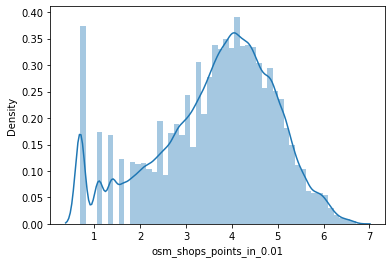

In [2882]:
log_col(full_cols[50], 2)

#### osm_subway_closest_dist

In [2883]:
data[full_cols[51]]

0       269.024986
1       102.455451
2       243.361937
3       295.633502
4         1.110429
           ...    
2969      3.931040
2970    201.668316
2971    140.244140
2972      1.657414
2973      2.114953
Name: osm_subway_closest_dist, Length: 282766, dtype: float64

osm_subway_closest_dist
IQR = 323.62018504210226
Нижняя граница: -484.18123269556355
Верхняя граница: 810.2995074728454
Число выбросов: 4424


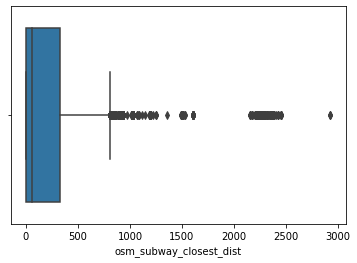

In [2884]:
sns.boxplot(data[full_cols[51]])
detect_outlires(data[full_cols[51]])

osm_subway_closest_dist
IQR = 4.975990542847286
Нижняя граница: -6.653480191475057
Верхняя граница: 13.250481979914086
Число выбросов: 0


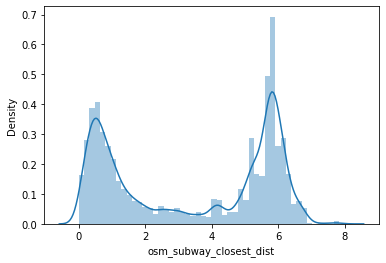

In [2885]:
log_col(full_cols[51])

#### osm_train_stop_closest_dist

In [2886]:
data[full_cols[52]].describe()

count    282766.000000
mean          9.627864
std          26.648942
min           0.001644
25%           1.343629
50%           2.731583
75%           5.820624
max        1321.700776
Name: osm_train_stop_closest_dist, dtype: float64

osm_train_stop_closest_dist
IQR = 4.476994735305155
Нижняя граница: -5.371862713601429
Верхняя граница: 12.53611622761919
Число выбросов: 34172


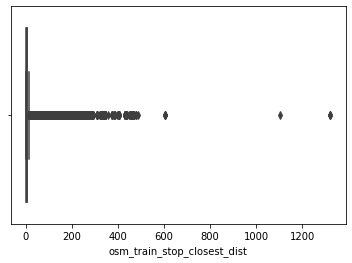

In [2887]:
sns.boxplot(data[full_cols[52]])
detect_outlires(data[full_cols[52]])

osm_train_stop_closest_dist
IQR = 1.068250232677076
Нижняя граница: -0.7506746001444797
Верхняя граница: 3.5223263305638244
Число выбросов: 21853


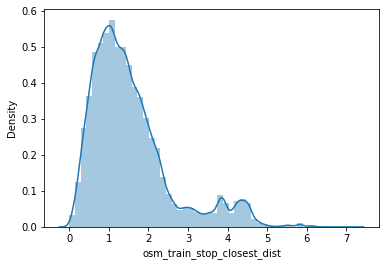

In [2888]:
log_col(full_cols[52], 1)

osm_train_stop_closest_dist
IQR = 0.5665119849699785
Нижняя граница: -0.5120816575090257
Верхняя граница: 1.7539662823708881
Число выбросов: 1064


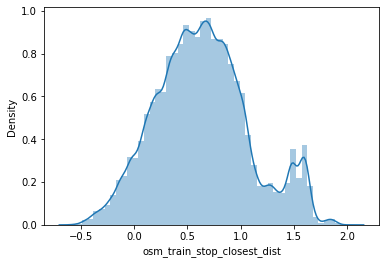

In [2889]:
log_col(full_cols[52], 0.55)

In [2890]:
data[full_cols[52]] = data[full_cols[52]].apply(
    lambda x: 1.75 if x > 1.75 else x)
data[full_cols[52]] = data[full_cols[52]].apply(
    lambda x: -0.51 if x < -0.51 else x)

#### osm_train_stop_points_in_0.005

In [2891]:
data[full_cols[53]].describe()

count    282766.000000
mean          0.078362
std           0.529536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: osm_train_stop_points_in_0.005, dtype: float64

osm_train_stop_points_in_0.005
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 10208


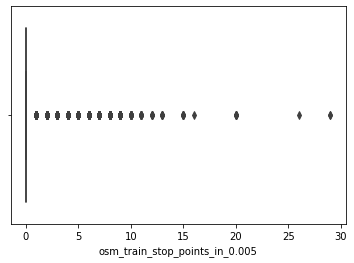

In [2892]:
sns.boxplot(data[full_cols[53]])
detect_outlires(data[full_cols[53]])

In [2893]:
data.drop('osm_train_stop_points_in_0.005', axis=1, inplace=True)

#### osm_train_stop_points_in_0.0075

In [2894]:
data[full_cols[54]].describe()

count    282766.000000
mean          0.195738
std           0.912876
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          31.000000
Name: osm_train_stop_points_in_0.0075, dtype: float64

osm_train_stop_points_in_0.0075
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 21505


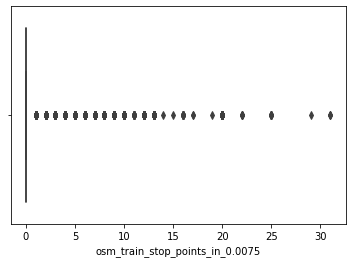

In [2895]:
sns.boxplot(data[full_cols[54]])
detect_outlires(data[full_cols[54]])

In [2896]:
data.drop('osm_train_stop_points_in_0.0075', axis=1, inplace=True)

#### osm_train_stop_points_in_0.01

In [2897]:
data[full_cols[55]].describe()

count    282766.000000
mean          0.346718
std           1.309099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          31.000000
Name: osm_train_stop_points_in_0.01, dtype: float64

osm_train_stop_points_in_0.01
IQR = 0.0
Нижняя граница: 0.0
Верхняя граница: 0.0
Число выбросов: 36196


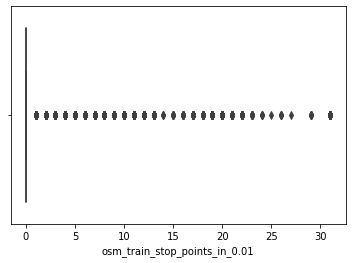

In [2898]:
sns.boxplot(data[full_cols[55]])
detect_outlires(data[full_cols[55]])

In [2899]:
data.drop('osm_train_stop_points_in_0.01', axis=1, inplace=True)

#### osm_transport_stop_closest_dist

In [2900]:
data[full_cols[56]].describe()

count    282766.000000
mean          0.571429
std           4.572858
min           0.000475
25%           0.098863
50%           0.175695
75%           0.312117
max        1006.664769
Name: osm_transport_stop_closest_dist, dtype: float64

osm_transport_stop_closest_dist
IQR = 0.2132540077342089
Нижняя граница: -0.2210184225593693
Верхняя граница: 0.6319976083774663
Число выбросов: 26707


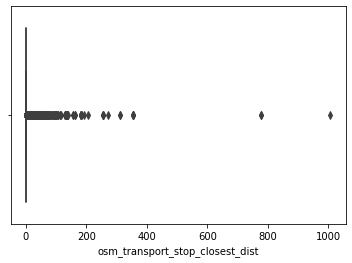

In [2901]:
sns.boxplot(data[full_cols[56]])
detect_outlires(data[full_cols[56]])

In [2902]:
data.drop('osm_transport_stop_closest_dist', axis=1, inplace=True)

#### osm_transport_stop_points_in_0.005

In [2903]:
data[full_cols[57]].describe()

count    282766.000000
mean          6.274524
std           5.557965
min           0.000000
25%           2.000000
50%           5.000000
75%           9.000000
max          58.000000
Name: osm_transport_stop_points_in_0.005, dtype: float64

osm_transport_stop_points_in_0.005
IQR = 7.0
Нижняя граница: -8.5
Верхняя граница: 19.5
Число выбросов: 8041


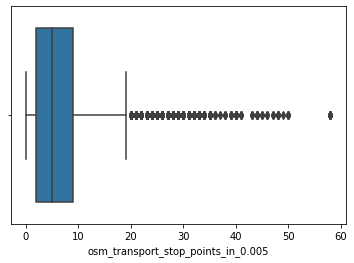

In [2904]:
sns.boxplot(data[full_cols[57]])
detect_outlires(data[full_cols[57]])

osm_transport_stop_points_in_0.005
IQR = 1.2039728043259361
Нижняя граница: -0.7073469178207945
Верхняя граница: 4.108544299482951
Число выбросов: 0


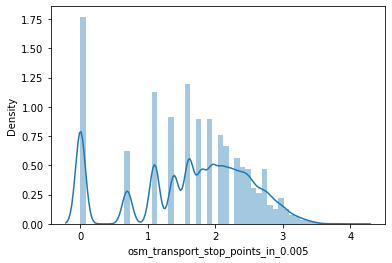

In [2905]:
log_col(full_cols[57])

#### osm_transport_stop_points_in_0.0075

In [2906]:
data[full_cols[58]].describe()

count    282766.000000
mean         12.972631
std          10.199296
min           0.000000
25%           5.000000
50%          11.000000
75%          19.000000
max          78.000000
Name: osm_transport_stop_points_in_0.0075, dtype: float64

osm_transport_stop_points_in_0.0075
IQR = 14.0
Нижняя граница: -16.0
Верхняя граница: 40.0
Число выбросов: 3953


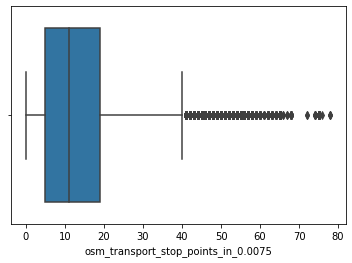

In [2907]:
sns.boxplot(data[full_cols[58]])
detect_outlires(data[full_cols[58]])

osm_transport_stop_points_in_0.0075
IQR = 1.203972804325936
Нижняя граница: -0.014199737260848888
Верхняя граница: 4.801691480042894
Число выбросов: 0


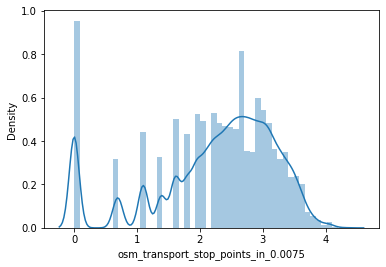

In [2908]:
log_col(full_cols[58])

#### osm_transport_stop_points_in_0.01

In [2909]:
data[full_cols[59]].describe()

count    282766.000000
mean         21.646093
std          16.245022
min           0.000000
25%           9.000000
50%          19.000000
75%          32.000000
max         109.000000
Name: osm_transport_stop_points_in_0.01, dtype: float64

osm_transport_stop_points_in_0.01
IQR = 23.0
Нижняя граница: -25.5
Верхняя граница: 66.5
Число выбросов: 3724


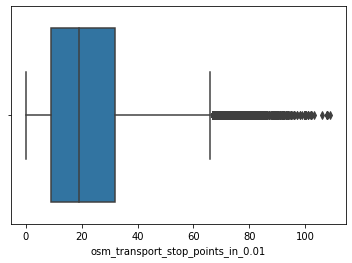

In [2910]:
sns.boxplot(data[full_cols[59]])
detect_outlires(data[full_cols[59]])

osm_transport_stop_points_in_0.01
IQR = 0.9718605830289659
Нижняя граница: 1.1812664550718095
Верхняя граница: 5.068708787187673
Число выбросов: 0


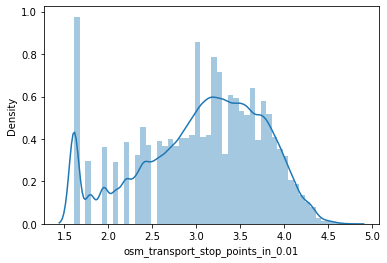

In [2911]:
log_col(full_cols[59], 5)

#### reform_count_of_houses_1000

In [2912]:
data[full_cols[60]].describe()

count    282766.000000
mean        101.012311
std          85.796433
min           0.000000
25%          39.000000
50%          86.000000
75%         141.000000
max         733.000000
Name: reform_count_of_houses_1000, dtype: float64

reform_count_of_houses_1000
IQR = 102.0
Нижняя граница: -114.0
Верхняя граница: 294.0
Число выбросов: 8382


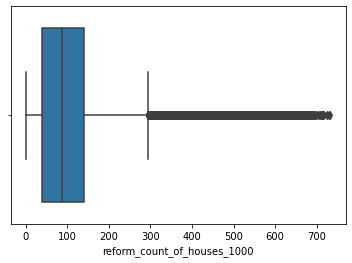

In [2913]:
sns.boxplot(data[full_cols[60]])
detect_outlires(data[full_cols[60]])

reform_count_of_houses_1000
IQR = 1.2155336267270118
Нижняя граница: 1.9378996756030447
Верхняя граница: 6.800034182511092
Число выбросов: 19991


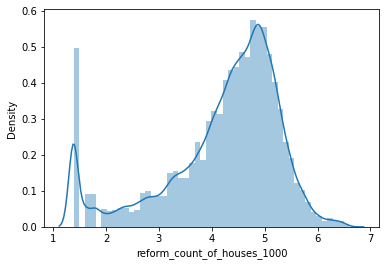

In [2914]:
log_col(full_cols[60], 4)

#### reform_count_of_houses_500

In [2915]:
data[full_cols[61]].describe()

count    282766.000000
mean         30.270354
std          27.766302
min           0.000000
25%          10.000000
50%          25.000000
75%          44.000000
max         289.000000
Name: reform_count_of_houses_500, dtype: float64

reform_count_of_houses_500
IQR = 34.0
Нижняя граница: -41.0
Верхняя граница: 95.0
Число выбросов: 7554


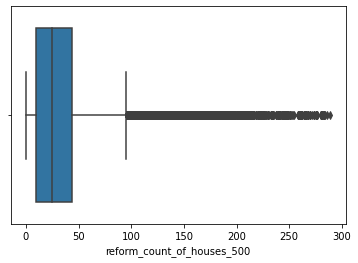

In [2916]:
sns.boxplot(data[full_cols[61]])
detect_outlires(data[full_cols[61]])

reform_count_of_houses_500
IQR = 1.3437347467010947
Нижняя граница: 0.4693045297363585
Верхняя граница: 5.844243516540737
Число выбросов: 0


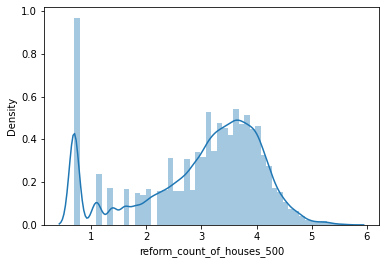

In [2917]:
log_col(full_cols[61], 2)

#### region

In [2918]:
data[full_cols[62]]

0               Пермский край
1          Московская область
2         Ярославская область
3         Кемеровская область
4                      Москва
                ...          
2969        Красноярский край
2970          Томская область
2971        Калужская область
2972    Нижегородская область
2973    Нижегородская область
Name: region, Length: 282766, dtype: object

In [2919]:
data[full_cols[62]] = data[full_cols[62]].apply(lambda x: x.lower())

In [2920]:
data[full_cols[62]].nunique()

49

#### total_square

In [2921]:
data[full_cols[63]].describe()

count    282766.000000
mean        506.770300
std        1698.801594
min           5.100000
25%          66.000000
50%         129.151158
75%         337.000000
max       40000.000000
Name: total_square, dtype: float64

total_square
IQR = 271.0
Нижняя граница: -340.5
Верхняя граница: 743.5
Число выбросов: 35840


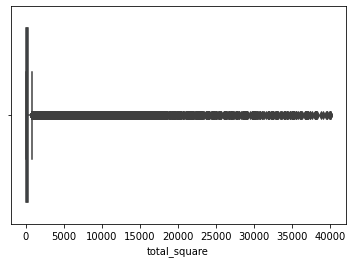

In [2922]:
sns.boxplot(data[full_cols[63]])
detect_outlires(data[full_cols[63]])

total_square
IQR = 1.6183532760920532
Нижняя граница: 1.777162705252886
Верхняя граница: 8.250575809621099
Число выбросов: 6130


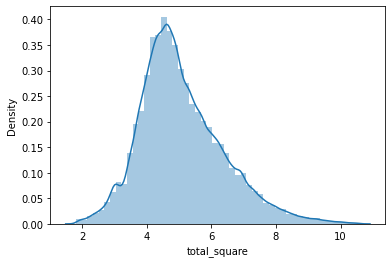

In [2923]:
log_col(full_cols[63])

total_square
IQR = 0.31914509146128434
Нижняя граница: 0.9809880973002708
Верхняя граница: 2.2575684631454083
Число выбросов: 4474


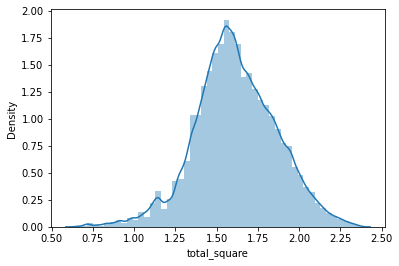

In [2924]:
log_col(full_cols[63], 0.1)

In [2925]:
data[full_cols[63]] = data[full_cols[63]].apply(
    lambda x: 2.25 if x > 2.25 else x)
data[full_cols[63]] = data[full_cols[63]].apply(
    lambda x: 0.98 if x < 0.98 else x)

#### date

Посмотрим на распределение дат и пока оставим признак в покое

In [2926]:
data[full_cols[64]]

0       2020-01-05
1       2020-01-05
2       2020-01-05
3       2020-01-05
4       2020-01-05
           ...    
2969    2020-12-27
2970    2020-12-27
2971    2020-12-27
2972    2020-12-27
2973    2020-12-27
Name: date, Length: 282766, dtype: object

In [2927]:
data.date = pd.to_datetime(data.date, format='%Y-%m-%d')

In [2928]:
data.date.describe()

count                  282766
unique                     51
top       2020-06-14 00:00:00
freq                    11047
first     2020-01-05 00:00:00
last      2020-12-27 00:00:00
Name: date, dtype: object

Посчитаем уникальные значение и их количество для следующих 2 признаков

#### realty_type

In [2929]:
data[full_cols[65]].describe()

count    282766.000000
mean         54.999257
std          47.850297
min          10.000000
25%          10.000000
50%          10.000000
75%         110.000000
max         110.000000
Name: realty_type, dtype: float64

In [2930]:
data[full_cols[65]].value_counts()

10     149700
110     74832
100     58234
Name: realty_type, dtype: int64

#### price_type

In [2931]:
data[full_cols[66]].value_counts()

0    275299
1      7467
Name: price_type, dtype: int64

## <center>Cols with NULL</center>

#### floor

In [2932]:
data[cols_with_null[0]].isnull().sum()

177538

Слишком много пропусков, поэтому единственное, что можно сделать это присвоить значение 0 пропускам и 1 заполненным значениям

In [2933]:
data.floor = data.floor.apply(lambda x: 0 if pd.isnull(x) else 1)

#### osm_city_nearest_population

In [2934]:
data[data.label == 0][cols_with_null[1]].isnull().sum()

55

In [2935]:
data[data.label == 1][cols_with_null[1]].isnull().sum()

0

Можем удалить строки с признаками, т.к. в тестовой выборке нет пропусков

In [2936]:
data = data.dropna(subset=['osm_city_nearest_population'])

osm_city_nearest_population
IQR = 1206583.0
Нижняя граница: -1547624.5
Верхняя граница: 3278707.5
Число выбросов: 56064


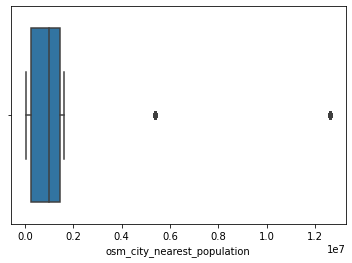

In [2937]:
sns.boxplot(data[cols_with_null[1]])
detect_outlires(data[cols_with_null[1]])

osm_city_nearest_population
IQR = 1.7229221073219367
Нижняя граница: 9.892674178423754
Верхняя граница: 16.7843626077115
Число выбросов: 0


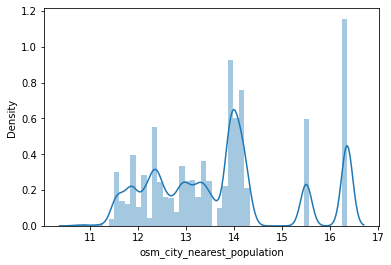

In [2938]:
log_col(cols_with_null[1])

#### per_square_meter_price

In [2939]:
data[data.label == 0][cols_with_null[2]].isnull().sum()

0

In [2940]:
data[data.label == 1][cols_with_null[2]].isnull().sum()

2974

per_square_meter_price
IQR = 89600.85470085475
Нижняя граница: -104679.0598290599
Верхняя граница: 253724.3589743591
Число выбросов: 24750


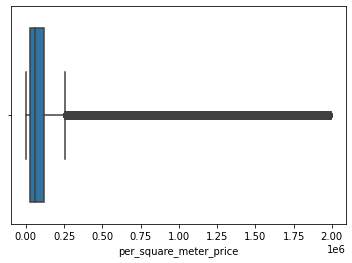

In [2941]:
sns.boxplot(data[data.label == 0][cols_with_null[2]])
detect_outlires(data[data.label == 0][cols_with_null[2]])

<AxesSubplot:xlabel='per_square_meter_price', ylabel='Density'>

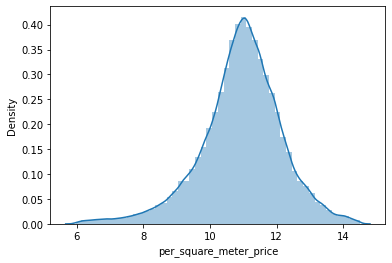

In [2942]:
data.per_square_meter_price = np.log(data.per_square_meter_price + 1)
sns.distplot(data.per_square_meter_price)

#### reform_house_population_1000

In [2943]:
data[data.label == 0][cols_with_null[3]].isnull().sum()

14591

In [2944]:
data[data.label == 1][cols_with_null[3]].isnull().sum()

35

In [2945]:
data[cols_with_null[3]].describe()

count    268085.000000
mean       2049.121682
std        1361.875750
min           0.000000
25%         944.000000
50%        1956.000000
75%        2982.000000
max       18392.000000
Name: reform_house_population_1000, dtype: float64

Заполним пропуски медианой

In [2946]:
data[cols_with_null[3]] = data[cols_with_null[3]].fillna(
    data[cols_with_null[3]].median())

reform_house_population_1000
IQR = 1917.0
Нижняя граница: -1878.5
Верхняя граница: 5789.5
Число выбросов: 1415


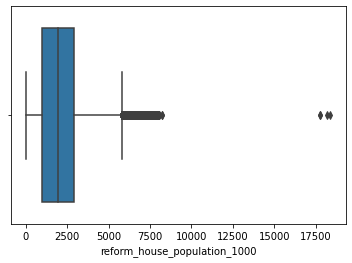

In [2947]:
sns.boxplot(data[data.label == 0][cols_with_null[3]])
detect_outlires(data[data.label == 0][cols_with_null[3]])

reform_house_population_1000
IQR = 1.0056544124907543
Нижняя граница: 5.498213608100909
Верхняя граница: 9.520831258063925
Число выбросов: 19807


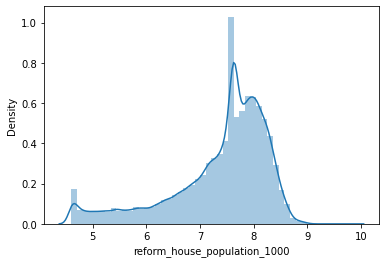

In [2948]:
log_col(cols_with_null[3], 100)

In [2949]:
data[cols_with_null[3]] = data[cols_with_null[3]].apply(
    lambda x: 9.52 if x > 9.52 else x)
data[cols_with_null[3]] = data[cols_with_null[3]].apply(
    lambda x: 5.49 if x < 5.49 else x)

#### reform_house_population_500

In [2950]:
data[cols_with_null[4]].describe()

count    255441.000000
mean        646.213149
std         445.908246
min           0.000000
25%         292.000000
50%         604.000000
75%         937.000000
max        6105.000000
Name: reform_house_population_500, dtype: float64

In [2951]:
data[data.label == 0][cols_with_null[4]].isnull().sum()

27222

In [2952]:
data[data.label == 1][cols_with_null[4]].isnull().sum()

48

Заполним пропуски медианой

In [2953]:
data[cols_with_null[4]] = data[cols_with_null[4]].fillna(
    data[cols_with_null[4]].median())

reform_house_population_500
IQR = 576.0
Нижняя граница: -542.0
Верхняя граница: 1762.0
Число выбросов: 3624


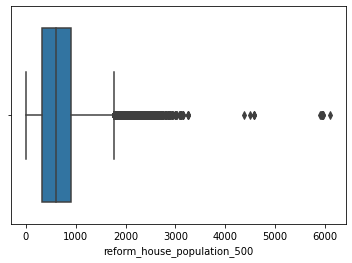

In [2954]:
sns.boxplot(data[cols_with_null[4]])
detect_outlires(data[cols_with_null[4]])

reform_house_population_500
IQR = 0.8607479622754521
Нижняя граница: 4.753883370622834
Верхняя граница: 8.196875219724642
Число выбросов: 10323


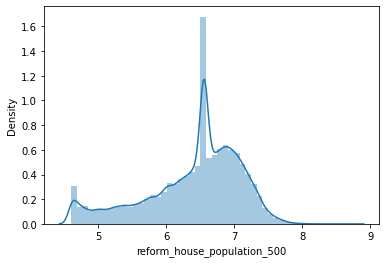

In [2955]:
log_col(cols_with_null[4], 100)

In [2956]:
data[cols_with_null[4]] = data[cols_with_null[4]].apply(
    lambda x: 8.19 if x > 8.19 else x)
data[cols_with_null[4]] = data[cols_with_null[4]].apply(
    lambda x: 4.75 if x < 4.75 else x)

#### reform_mean_floor_count_1000

In [2957]:
data[cols_with_null[5]].describe()

count    265975.000000
mean          7.042503
std           3.533509
min           0.000000
25%           4.593220
50%           6.357143
75%           8.684211
max          53.717949
Name: reform_mean_floor_count_1000, dtype: float64

In [2958]:
data[data.label == 0][cols_with_null[5]].isnull().sum()

16701

In [2959]:
data[data.label == 1][cols_with_null[5]].isnull().sum()

35

In [2960]:
data[cols_with_null[5]] = data[cols_with_null[5]].fillna(
    data[cols_with_null[5]].median())

reform_mean_floor_count_1000
IQR = 3.7751695357329167
Нижняя граница: -0.9590505998956713
Верхняя граница: 14.141627543035995
Число выбросов: 13160


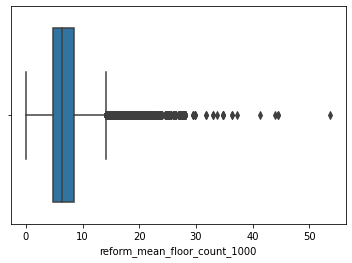

In [2961]:
sns.boxplot(data[cols_with_null[5]])
detect_outlires(data[cols_with_null[5]])

reform_mean_floor_count_1000
IQR = 0.5079497161941124
Нижняя граница: 0.9791911621181313
Верхняя граница: 3.0109900268945813
Число выбросов: 3440


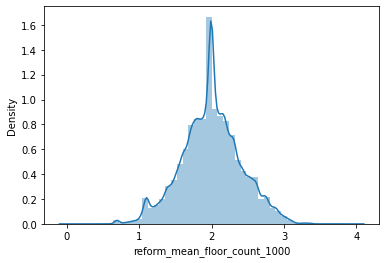

In [2962]:
log_col(cols_with_null[5])

In [2963]:
data[cols_with_null[5]] = data[cols_with_null[5]].apply(
    lambda x: 3 if x > 3 else x)
data[cols_with_null[5]] = data[cols_with_null[5]].apply(
    lambda x: 0.98 if x < 0.98 else x)

#### reform_mean_floor_count_500

In [2964]:
data[cols_with_null[6]].describe()

count    252507.000000
mean          7.350435
std           4.220349
min           0.000000
25%           4.619048
50%           6.384615
75%           9.083333
max         221.666667
Name: reform_mean_floor_count_500, dtype: float64

In [2965]:
data[data.label == 0][cols_with_null[6]].isnull().sum()

30156

In [2966]:
data[data.label == 1][cols_with_null[6]].isnull().sum()

48

In [2967]:
data[cols_with_null[6]] = data[cols_with_null[6]].fillna(
    data[cols_with_null[6]].median())

reform_mean_floor_count_500
IQR = 3.875618811881189
Нижняя граница: -1.001547029702973
Верхняя граница: 14.500928217821784
Число выбросов: 16390


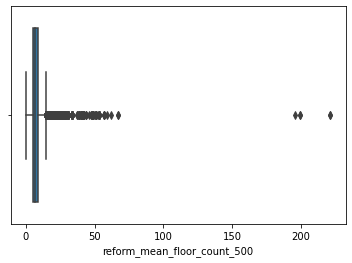

In [2968]:
sns.boxplot(data[cols_with_null[6]])
detect_outlires(data[cols_with_null[6]])

In [2969]:
data[(data.label == 1) & (data['reform_mean_floor_count_500'] > 150)]

,city,floor,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.0075,osm_building_points_in_0.01,...,reform_mean_floor_count_500,reform_mean_year_building_1000,reform_mean_year_building_500,region,total_square,street,date,realty_type,price_type,label


In [2970]:
data = data[data['reform_mean_floor_count_500'] < 150]

reform_mean_floor_count_500
IQR = 3.875618811881189
Нижняя граница: -1.001547029702973
Верхняя граница: 14.500928217821784
Число выбросов: 16385


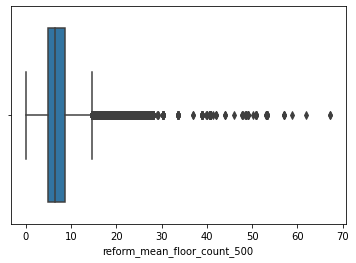

In [2971]:
sns.boxplot(data[cols_with_null[6]])
detect_outlires(data[cols_with_null[6]])

reform_mean_floor_count_500
IQR = 0.5109320916926283
Нижняя граница: 0.9935061654478944
Верхняя граница: 3.037234532218408
Число выбросов: 6402


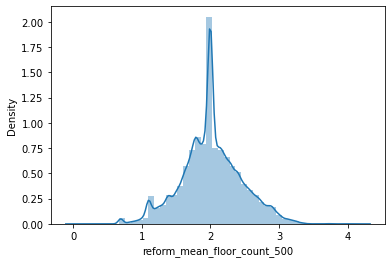

In [2972]:
log_col(cols_with_null[6])

In [2973]:
data[cols_with_null[6]] = data[cols_with_null[6]].apply(
    lambda x: 3 if x > 3 else x)
data[cols_with_null[6]] = data[cols_with_null[6]].apply(
    lambda x: 0.99 if x < 0.99 else x)

#### reform_mean_year_building_1000

In [2974]:
data[cols_with_null[7]].describe()

count    266439.000000
mean       1967.499984
std          45.681224
min           1.000000
25%        1960.060606
50%        1970.870968
75%        1983.647580
max        2019.000000
Name: reform_mean_year_building_1000, dtype: float64

In [2975]:
data[data.label == 0][cols_with_null[7]].isnull().sum()

16232

In [2976]:
data[data.label == 1][cols_with_null[7]].isnull().sum()

35

In [2977]:
data[cols_with_null[7]] = data[cols_with_null[7]].fillna(
    data[cols_with_null[7]].median())

reform_mean_year_building_1000
IQR = 21.553109605911686
Нижняя граница: 1928.6703355911325
Верхняя граница: 2014.8827740147792
Число выбросов: 24314


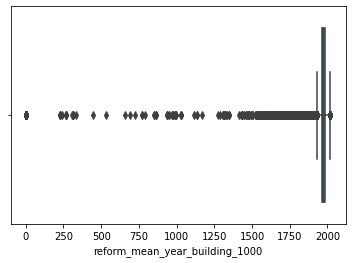

In [2978]:
sns.boxplot(data[cols_with_null[7]])
detect_outlires(data[cols_with_null[7]])

In [2979]:
data.drop('reform_mean_year_building_1000', axis=1, inplace=True)

#### reform_mean_year_building_500

In [2980]:
data[cols_with_null[8]].describe()

count    253033.000000
mean       1967.956961
std          53.941775
min           1.000000
25%        1959.875000
50%        1971.630435
75%        1986.913043
max        2020.000000
Name: reform_mean_year_building_500, dtype: float64

In [2981]:
data[data.label == 0][cols_with_null[8]].isnull().sum()

29625

In [2982]:
data[data.label == 1][cols_with_null[8]].isnull().sum()

48

In [2983]:
data[cols_with_null[8]] = data[cols_with_null[8]].fillna(
    data[cols_with_null[8]].median())

reform_mean_year_building_500
IQR = 23.33333333333394
Нижняя граница: 1926.3333333333321
Верхняя граница: 2019.6666666666679
Число выбросов: 17144


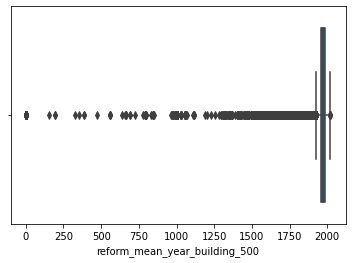

In [2984]:
sns.boxplot(data[cols_with_null[8]])
detect_outlires(data[cols_with_null[8]])

In [2985]:
data.drop('reform_mean_year_building_500', axis=1, inplace=True)

#### street

In [2986]:
data[cols_with_null[9]]

0       S27289
1       S17052
2       S16913
3       S10148
4        S1338
         ...  
2969     S2650
2970    S11114
2971    S34005
2972    S21753
2973    S28997
Name: street, Length: 282706, dtype: object

In [2987]:
data[data.label == 0][cols_with_null[9]].isnull().sum()

1604

In [2988]:
data[data.label == 0][cols_with_null[9]].value_counts()

S12711    4990
S24233    2664
S20099    2249
S14617    1785
S9675     1446
          ... 
S16234       1
S3956        1
S18051       1
S12138       1
S13099       1
Name: street, Length: 28825, dtype: int64

In [2989]:
data[data.label == 1][cols_with_null[9]].isnull().sum()

6

In [2990]:
data[data.label == 1][cols_with_null[9]].value_counts()

S12711    74
S9675     44
S24233    32
S13992    31
S10922    27
          ..
S30151     1
S27348     1
S24323     1
S7341      1
S34005     1
Name: street, Length: 1138, dtype: int64

Удалим бесполезный признак, т.к. слишком много уникальных

In [2991]:
data.drop('street', axis=1, inplace=True)

Сохраним датасет после обработки

In [2992]:
data.to_csv('data_EDA.csv')